In [ ]:
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(harmony))

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(repr)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

In [ ]:
corder <- c('Lymphoid','Myeloid','Endocardial','Endothelial','Adipocyte',
            'Fibroblast','Neuronal','Pericyte','SM','Epicardial','aCM','vCM')

celltype_colors <- c(
    vCM = "#b94656",
    aCM = "#b95c38",
    Fibroblast = "#c0a13b",
    SM = "#71893b",
    Pericyte = "#6dbc5f",
    Epicardial = "#45c097",
    Endocardial = "#628ed6",
    Endothelial = "#6a70d7",
    Neuronal = "#5a3687",
    Myeloid = "#c074cc",
    Lymphoid = "#d16bad",
    Adipocyte = "#aa3d71"
)

cellsubtype_colors <- c(
    "#ac6175","#d4436b","#d54259","#c56969","#d44248","#b88077","#d23e31","#e83c21","#c27153","#c5663d","#ce632a","#e76717","#d53bc6",
    "#e04dbe","#d175b3","#cd3b9e","#9b5c82","#d5a1b9","#e74590","#be457a",
    "#ac7a61","#de9165","#a55f35","#7c5a3a","#e9c49b","#bb9c71","#bc924a","#84651d","#897244","#e6c572","#9f8e33",
    "#d1dc33","#b8c251",
    "#b0b69a","#708838","#b8d38b","#748b5a","#72d943","#65c45e",
    "#326d74","#143b44","#4a5967","#45617f","#27313f",
    "#3c6695","#0d1724",
    "#293251","#515ea0","#363e77","#4a5cc4","#121331","#1f225e","#2c2f94","#150e3f",
    "#5a3e98","#612eba","#402c53","#481f73",
    "#c68bdc","#cd6ee4","#da49f0","#d592cd","#df70c7","#eb4bcd","#ee4a9f","#e27eab",
    "#44dd94","#9fd5b5","#438867","#60d2a2","#afd9d0","#468c80","#6a827d","#5ad7cb",
    "#3c7ae7","#5f94e1","#3765ae"
)

## Read objects

In [10]:
obj <- qs::qread("integration/CAREHF_Multiome_DPT_RNA_int.obj.qs") ### RNA only
int <- qs::qread("../../87.FNIH_DHC_IGM_240925/05.R/integration/All_data.int.qs") ### include HiC

obj

An object of class Seurat 
73992 features across 713384 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 layers present: data, scale.data
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [53]:
### modify donor information and subtype information
int@meta.data[int$orig.ident == "CAREHF" & int$DONOR == 'D1', ]$DONOR <- "D36"
int@meta.data[int$orig.ident == "CAREHF" & int$DONOR == 'D2', ]$DONOR <- "D38"
int@meta.data[int$orig.ident == "CAREHF" & int$DONOR == 'HF3', ]$DONOR <- "DTX031"
int@meta.data[int$orig.ident == "CAREHF" & int$DONOR == 'HF6', ]$DONOR <- "DTX065"

obj@meta.data[obj$orig.ident == "CAREHF" & obj$DONOR == 'D1', ]$DONOR <- "D36"
obj@meta.data[obj$orig.ident == "CAREHF" & obj$DONOR == 'D2', ]$DONOR <- "D38"
obj@meta.data[obj$orig.ident == "CAREHF" & obj$DONOR == 'HF3', ]$DONOR <- "DTX031"
obj@meta.data[obj$orig.ident == "CAREHF" & obj$DONOR == 'HF6', ]$DONOR <- "DTX065"

In [58]:
smatch <- read.table("../reference/MULTIOME_subtype_rename.250324", header = T)
smatch[smatch$old == "FB4_myofibroblast",]$old <- "FB4_myo"
int@meta.data[int$predicted.cellsubtype %in% smatch$old,]$predicted.cellsubtype <- smatch[match(int@meta.data[int$predicted.cellsubtype %in% smatch$old,]$predicted.cellsubtype, smatch$old), ]$new
obj@meta.data[obj$nn2.cell_subtype %in% smatch$old,]$nn2.cell_subtype <- smatch[match(obj@meta.data[obj$nn2.cell_subtype %in% smatch$old,]$nn2.cell_subtype, smatch$old), ]$new

## Output figures

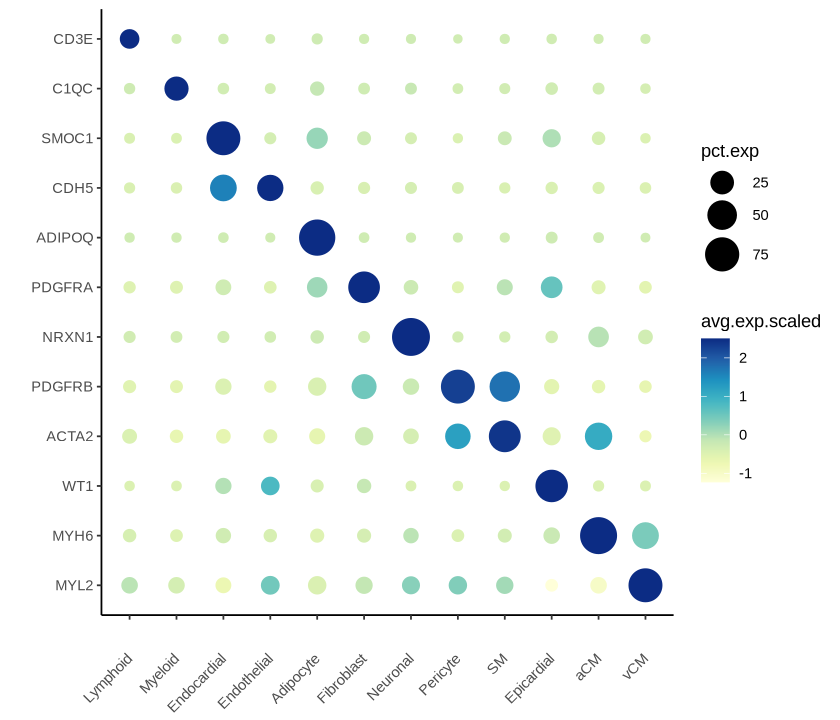

In [178]:
mtp <- c("MYL2", "MYH6", "WT1", "ACTA2", "PDGFRB", "NRXN1", "PDGFRA", "ADIPOQ", "CDH5", "SMOC1", "C1QC", "CD3E")

tmp <- subset(obj, subset = integrated_majortype == 1)
DefaultAssay(tmp) <- "RNA"
tmp$nn2.celltype <- factor(tmp$nn2.celltype, levels = corder)

tmp <- NormalizeData(tmp, normalization.method = "LogNormalize", scale.factor = 10000)
tmp <- ScaleData(tmp)

t1 <- DotPlot(tmp, features = mtp, group.by = "nn2.celltype") + 
scale_color_gradientn(colors = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25)) + 
ylab("") + xlab("") + 
scale_size(range = c(1, 8)) + coord_flip() + 
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1))

t1 <- t1$data %>%
filter(features.plot %in% mtp) %>%
mutate(features.plot = factor(features.plot, level = mtp)) %>%
mutate(id = factor(id, level = corder)) %>%
ggplot(aes(x = id, y = features.plot, color = avg.exp.scaled, size = pct.exp)) + 
geom_point() + 
scale_size(range = c(2, 10)) + 
scale_color_gradientn(colors = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25)) + 
ylab("") + xlab("") + theme_classic() + 
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1))

options(repr.plot.width = 7, repr.plot.height = 6)
t1

### Check gender bias

In [62]:
### Separation of all data on UMAP
library(lisi)
validc <- int@meta.data %>% filter(integrated_majortype == "1") %>% rownames
XX <- int@reductions$umap@cell.embeddings[validc,]

qry <- c("DONOR", "condition", "orig.ident", "tech")
tmeta <- int@meta.data[validc, qry]
tmeta$Gender <- dinfo[match(tmeta$DONOR, dinfo$Patient.ID),]$Gender

lisir <- compute_lisi(XX, tmeta, colnames(tmeta))

Warning message:
“package ‘lisi’ was built under R version 4.3.1”


In [310]:
apply(tmeta, MARGIN = 2, table)

$DONOR

    D1     D2     D3    D35    D36    D37    D38    D40    D47    D51    D52 
 28770  27933  23657  16273  16562  19249  25192  22090  16030  23459  16092 
   D53    D55     D7     D9 DTX017 DTX027 DTX031 DTX037 DTX060 DTX062 DTX065 
 28115  14280   8918  26539  14527   9622  19425  20888  19771  21218  12572 
DTX066 DTX077 DTX081 DTX087 DTX088 DTX089 DTX091 DTX093 DTX096 DTX097 DTX105 
 16590  19976  14989  16442  15694  18981  14636   7255  13713  12698  16093 
DTX114 DTX119    HF1    HF2    HF3    HF6    HF9 
 15835  23721  28711  18608  14474  33100  34824 

$condition

CONTROL      HF 
 313159  454363 

$orig.ident

  CAREHF      DHC      DPT MULTIOME 
  245534    63090   129643   329255 

$tech

    ATAC  H3K27ac H3K27me3     Hi-C 
  574789    67476    62167    63090 

$Gender

     F      M 
353217 414305 


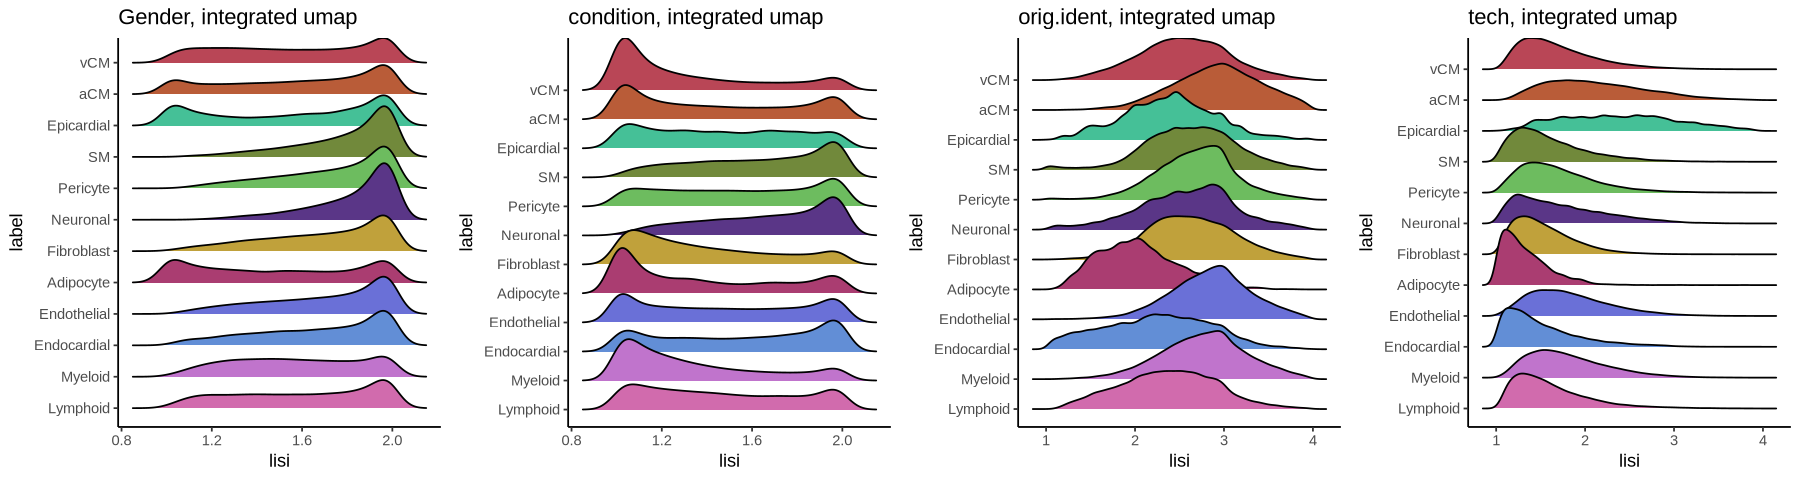

In [65]:
tgroup <- "Gender"
t1 <- merge(lisir[,c(tgroup), drop = F], int@meta.data[validc, "nn2.celltype",drop = F], by = 0) %>%
setNames(c("barcode", "lisi", "label")) %>%
mutate(label = factor(label, levels = corder)) %>%
ggplot(aes(x = lisi, y = label, fill = label)) + 
geom_density_ridges(bandwidth = 0.05) +
theme_classic() + 
scale_fill_manual(values = celltype_colors) + 
ggtitle(paste0(tgroup, ", integrated umap")) + NoLegend()

tgroup <- "condition"
t2 <- merge(lisir[,c(tgroup), drop = F], int@meta.data[validc, "nn2.celltype",drop = F], by = 0) %>%
setNames(c("barcode", "lisi", "label")) %>%
mutate(label = factor(label, levels = corder)) %>%
ggplot(aes(x = lisi, y = label, fill = label)) + 
geom_density_ridges(bandwidth = 0.05) +
theme_classic() + 
scale_fill_manual(values = celltype_colors) + 
ggtitle(paste0(tgroup, ", integrated umap")) + NoLegend()

tgroup <- "orig.ident"
t3 <- merge(lisir[,c(tgroup), drop = F], int@meta.data[validc, "nn2.celltype",drop = F], by = 0) %>%
setNames(c("barcode", "lisi", "label")) %>%
mutate(label = factor(label, levels = corder)) %>%
ggplot(aes(x = lisi, y = label, fill = label)) + 
geom_density_ridges(bandwidth = 0.05) +
theme_classic() + 
scale_fill_manual(values = celltype_colors) + 
ggtitle(paste0(tgroup, ", integrated umap")) + NoLegend()

tgroup <- "tech"
t4 <- merge(lisir[,c(tgroup), drop = F], int@meta.data[validc, "nn2.celltype",drop = F], by = 0) %>%
setNames(c("barcode", "lisi", "label")) %>%
mutate(label = factor(label, levels = corder)) %>%
ggplot(aes(x = lisi, y = label, fill = label)) + 
geom_density_ridges(bandwidth = 0.05) +
theme_classic() + 
scale_fill_manual(values = celltype_colors) + 
ggtitle(paste0(tgroup, ", integrated umap")) + NoLegend()

fig1 <- cowplot::plot_grid(t1, t2, t3, t4, ncol = 4)

options(repr.plot.width = 15, repr.plot.height = 4)
fig1

In [101]:
### UMAP of all
valid1 <- int@meta.data[int$orig.ident == "DHC",] %>% rownames
valid2 <- obj@meta.data[obj$integrated_majortype == "1",] %>% rownames
options(repr.plot.width = 8, repr.plot.height = 8)
t1 <- DimPlot(int, group.by = "nn2.celltype", cols = celltype_colors, label = F, 
              cells = c(valid1, valid2), raster = T) + theme_void() + NoLegend()
t1$layers[[1]]$aes_params$alpha = 0.2 
ggsave(t1, filename = "plot/FIG_alldata_umap.png", dpi = 300, height = 8, width = 8)

t2 <- DimPlot(int, group.by = "nn2.celltype", cols = celltype_colors, label = F, cells = c(valid1, valid2)) + theme_void()
ggsave(t2, filename = "plot/FIG_alldata_umap.pdf", dpi = 150, height = 8, width = 8)

write.table(t1$data, "plot/FIG_alldata_umap.xls", sep = "\t", quote = F, row.names = T, col.names = T)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


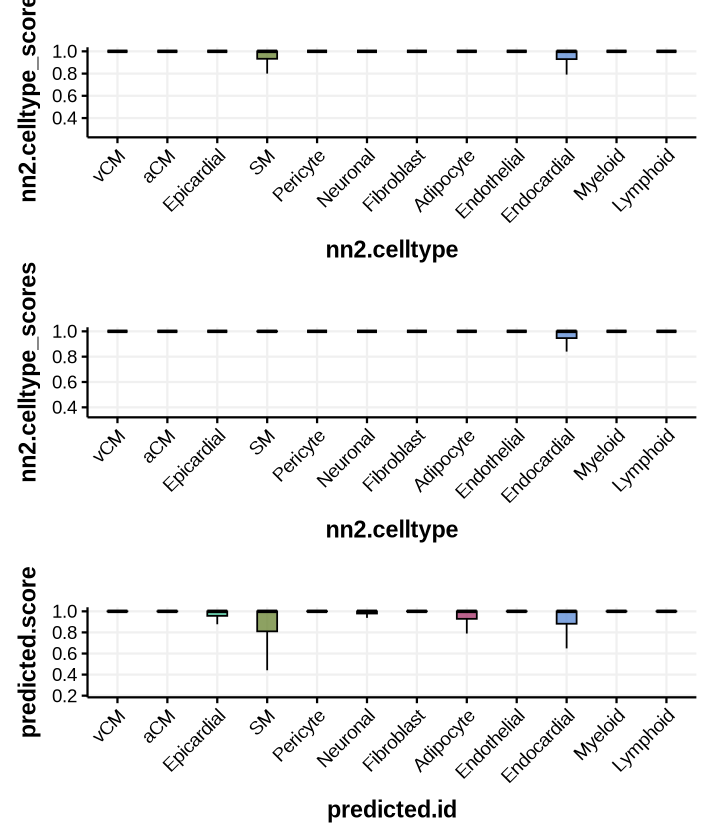

In [71]:
### output major types prediction score
t1 <- int@meta.data[int$orig.ident == "CAREHF",] %>%
mutate(nn2.celltype = factor(nn2.celltype, levels = rev(corder))) %>%
ggplot(aes(x = nn2.celltype, y = nn2.celltype_scores, fill = nn2.celltype)) +
geom_boxplot(width = 0.4, color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + 
scale_fill_manual(values = celltype_colors) + NoLegend()+
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

t2 <- int@meta.data[int$orig.ident == "DPT",] %>%
mutate(nn2.celltype = factor(nn2.celltype, levels = rev(corder))) %>%
ggplot(aes(x = nn2.celltype, y = nn2.celltype_scores, fill = nn2.celltype)) +
geom_boxplot(width = 0.4, color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + 
scale_fill_manual(values = celltype_colors) + NoLegend() +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

pred <- read.csv('../../87.FNIH_DHC_IGM_240925/05.R/integration/FNIH_DHC_genescore_prediction.metadata.csv', row.names = 1)
t3 <- pred %>%
mutate(predicted.id = factor(predicted.id, levels = rev(corder))) %>%
ggplot(aes(x = predicted.id, y = predicted.score, fill = predicted.id)) +
geom_boxplot(width = 0.4, color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + 
scale_fill_manual(values = celltype_colors) + NoLegend() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

fig1 <- cowplot::plot_grid(t1, t2, t3, nrow = 3)

options(repr.plot.width = 6, repr.plot.height = 7)
fig1

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


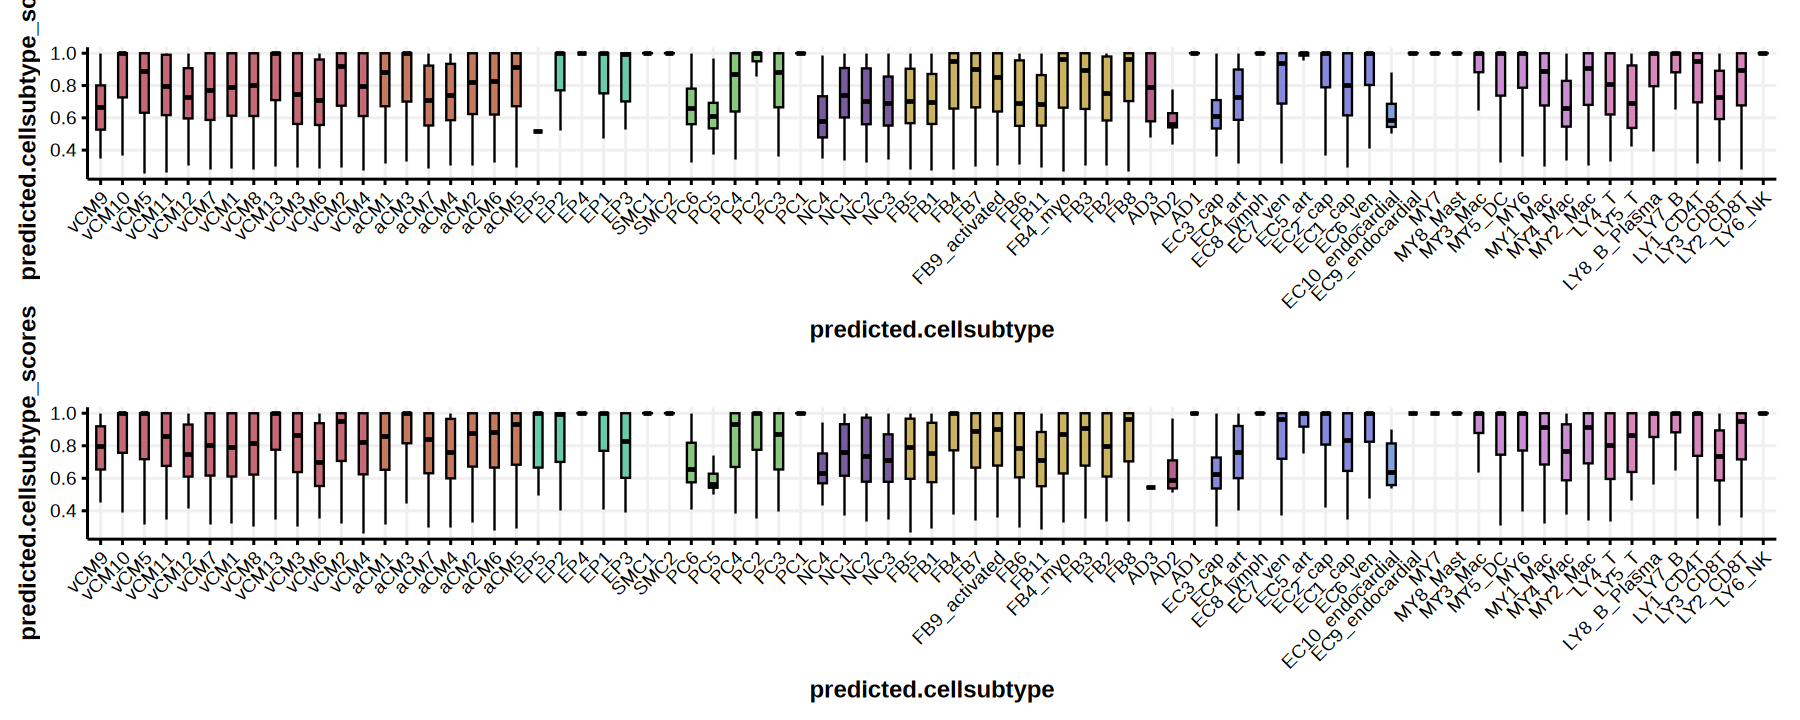

In [113]:
### output subtypes prediction score
qorder <- distinct(obj@meta.data[,c("predicted.celltype", "predicted.cellsubtype")]) %>%
mutate(predicted.celltype = gsub("label_", "", predicted.celltype)) %>%
mutate(predicted.celltype = factor(predicted.celltype, levels = corder)) %>%
arrange(predicted.celltype) %>%
dplyr::select(predicted.cellsubtype) %>% unlist %>% unique

t1 <- obj@meta.data[obj$orig.ident == "CAREHF",] %>%
mutate(predicted.celltype = gsub("label_", "", predicted.celltype)) %>%
mutate(predicted.cellsubtype = factor(predicted.cellsubtype, levels = rev(qorder))) %>%
ggplot(aes(x = predicted.cellsubtype, y = predicted.cellsubtype_scores, fill = predicted.celltype)) +
geom_boxplot(width = 0.4, color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + NoLegend() + scale_fill_manual(values = celltype_colors) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

t2 <- obj@meta.data[obj$orig.ident == "DPT",] %>%
mutate(predicted.celltype = gsub("label_", "", predicted.celltype)) %>%
mutate(predicted.cellsubtype = factor(predicted.cellsubtype, levels = rev(qorder))) %>%
ggplot(aes(x = predicted.cellsubtype, y = predicted.cellsubtype_scores, fill = predicted.celltype)) +
geom_boxplot(width = 0.4, color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() + NoLegend() + scale_fill_manual(values = celltype_colors) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

fig1 <- cowplot::plot_grid(t1, t2, nrow = 2)

options(repr.plot.width = 15, repr.plot.height = 6)
fig1

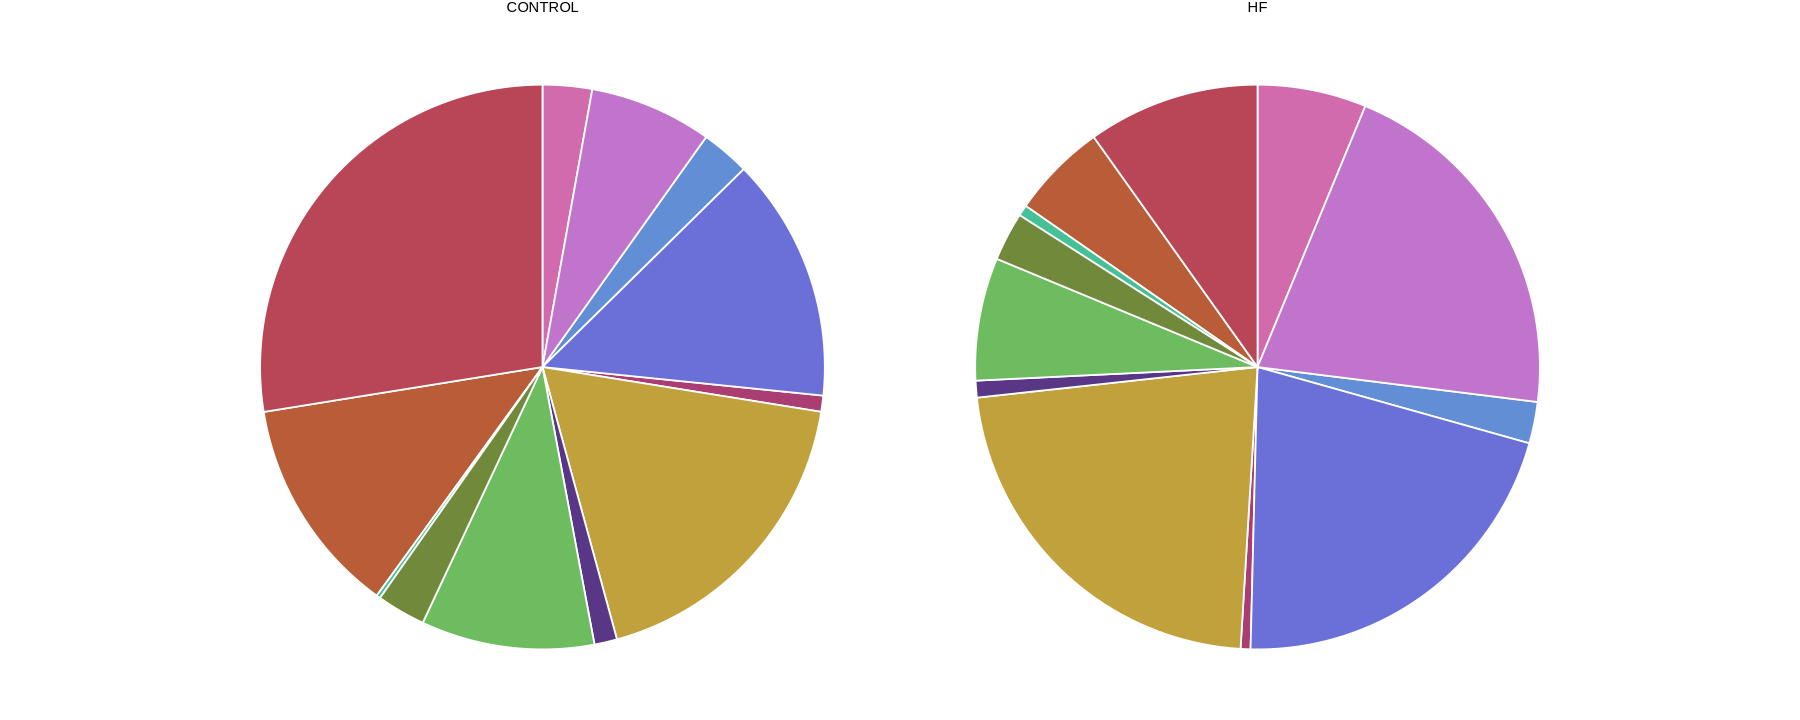

In [76]:
t1 <- int@meta.data[c(valid1, valid2),] %>% 
select(c(nn2.celltype, condition)) %>% table %>%
as.data.frame %>% 
mutate(nn2.celltype = factor(nn2.celltype, levels = rev(corder))) %>%
ggplot(aes(y = Freq, x = "", fill = nn2.celltype)) + 
geom_bar(stat = "identity", position = position_fill(), color = "white") + 
coord_polar(theta = "y") +
xlab("") + ylab("") +
theme_void() + 
scale_fill_manual(values = celltype_colors) + 
theme_void() + NoLegend() + 
facet_grid(. ~ condition)

t1

Warning message:
“package ‘ggthemes’ was built under R version 4.3.2”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


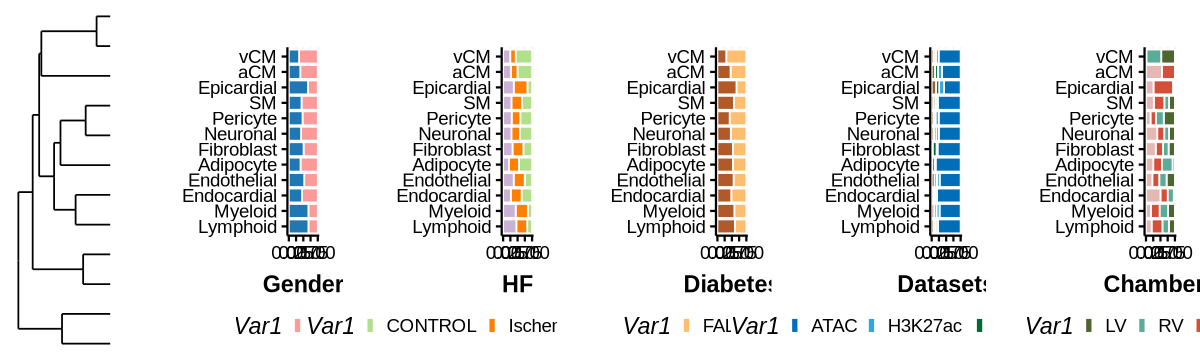

In [13]:
### columns of HF, Diabetes, Gender, chamber
gmeta <- int@meta.data[c(valid1, valid2),]

expr <- read.table("integration/CAREHF_Multiome_DPT_RNA_int.aggregatedExp.txt", header = T, row.names = 1)
tmp_cor <- cor(as.matrix(expr), method = "spearman")
Z = hclust(as.dist(1-tmp_cor), method = 'complete')

library(ggdendro)
ddo <- as.dendrogram(Z)
data <- dendro_data(ddo, type = "rectangle")
t0 <- ggplot(segment(data)) + 
geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
coord_flip() + 
scale_y_reverse(expand = c(0.2, 0)) + 
theme_void()

corder <- data$labels$label

t1 <- table(gmeta$Gender, gmeta$nn2.celltype) %>%
as.data.frame %>% 
mutate(Var2 = factor(Var2, levels = corder)) %>%
group_by(Var1) %>% mutate(ratio_in_tech = Freq / sum(Freq)) %>%
ungroup() %>%
ggplot(aes(y = Var2, x = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + xlab("Gender") + ylab("") +
theme_Publication() + scale_fill_manual(values = cols1)

t2 <- table(gmeta$HF, gmeta$nn2.celltype) %>%
as.data.frame %>% 
mutate(Var2 = factor(Var2, levels = corder)) %>%
group_by(Var1) %>% mutate(ratio_in_tech = Freq / sum(Freq)) %>%
ungroup() %>%
ggplot(aes(y = Var2, x = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + xlab("HF") + ylab("") +
theme_Publication() + scale_fill_manual(values = cols2)


t3 <- table(gmeta$Diabetes, gmeta$nn2.celltype) %>%
as.data.frame %>% 
mutate(Var2 = factor(Var2, levels = corder)) %>%
group_by(Var1) %>% mutate(ratio_in_tech = Freq / sum(Freq)) %>%
ungroup() %>%
ggplot(aes(y = Var2, x = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + xlab("Diabetes") + ylab("") +
theme_Publication() + scale_fill_manual(values = cols3)

t4 <- table(gmeta$tech, gmeta$nn2.celltype) %>%
as.data.frame %>% mutate(Var1 = factor(Var1, levels = c("ATAC", "H3K27ac", "Hi-C", "H3K27me3"))) %>%
mutate(Var2 = factor(Var2, levels = corder)) %>%
# group_by(Var1) %>% 
mutate(ratio_in_tech = Freq / sum(Freq)) %>%
# ungroup() %>%
ggplot(aes(y = Var2, x = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + xlab("Datasets") + ylab("") +
theme_Publication() + scale_fill_manual(values = cols4)

t5 <- table(gmeta$CHAMBER, gmeta$nn2.celltype) %>%
as.data.frame %>% mutate(Var1 = factor(Var1, levels = c("LV", "RV", "LA", "RA"))) %>%
mutate(Var2 = factor(Var2, levels = corder)) %>%
# group_by(Var1) %>% 
mutate(ratio_in_tech = Freq / sum(Freq)) %>%
# ungroup() %>%
ggplot(aes(y = Var2, x = ratio_in_tech, fill = Var1)) + 
geom_col(position = "fill", color = "white") + xlab("Chambers") + ylab("") +
theme_Publication() + scale_fill_manual(values = cols5)

t1 <- cowplot::plot_grid(t0, t1, t2, t3, t4, t5, ncol = 6, rel_widths = c(0.6,1,1,1,1,1))
t1
# ggsave(t1, filename = "plot/FIG_alldata_barplot_condition.pdf", dpi = 300, height = 5, width = 15)

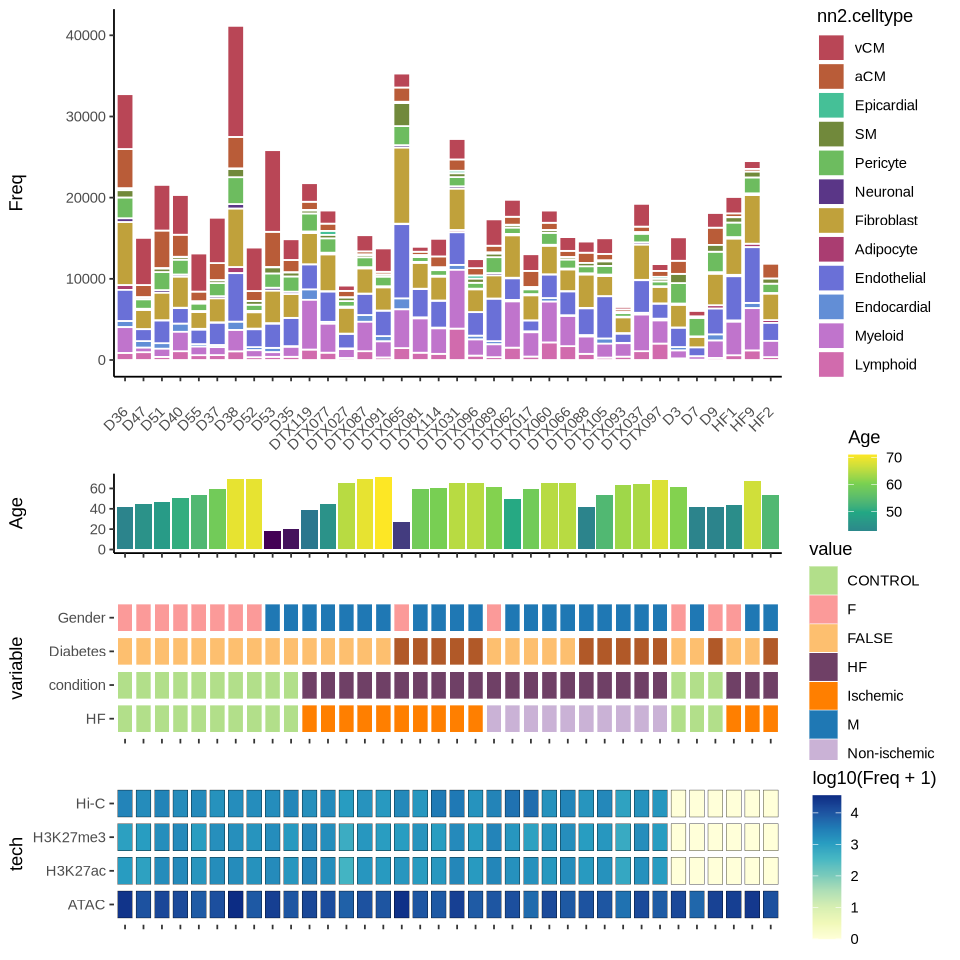

In [100]:
### Donor info and techniques summary, version 2
dinfo <- read.table("../reference/CAREHF_FNIH_donor.simple.info", sep = "\t") %>% 
filter(Patient.ID %in% unique(int$DONOR))

valid <- c(valid1, valid2) # int@meta.data[int$integrated_majortype == "1",] %>% rownames

t1 <- int@meta.data[valid, c("DONOR", "nn2.celltype")] %>%
table %>% as.data.frame %>%
mutate(nn2.celltype = factor(nn2.celltype, levels = rev(corder))) %>%
mutate(DONOR = factor(DONOR, levels = colnames(fdata))) %>%
arrange(DONOR) %>%
ggplot(aes(x = DONOR, y = Freq, fill = nn2.celltype)) + 
geom_col(color = "white") + 
theme_classic() + xlab("") + 
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)) + 
scale_fill_manual(values = celltype_colors)

t2 <- dinfo %>%
mutate(DONOR = factor(Patient.ID, levels = colnames(fdata))) %>%
arrange(DONOR) %>% distinct %>%
ggplot(aes(x = DONOR, y = Age, fill = Age)) + 
geom_col() + 
theme_classic() + xlab("") + 
theme(axis.text.x = element_blank()) + 
scale_fill_viridis_c()

t3 <- int@meta.data[valid,c("DONOR", "tech")] %>%
table %>% as.data.frame %>%
mutate(DONOR = factor(DONOR, levels = colnames(fdata))) %>%
arrange(DONOR) %>%
ggplot(aes(x = DONOR, y = tech, fill = log10(Freq + 1))) + 
geom_tile(color = "black", width=0.8, height=0.8) + 
theme_classic() + xlab("") + 
theme(axis.text.x = element_blank(), axis.line.x = element_blank(), axis.line.y = element_blank()) + 
scale_fill_gradientn(colors = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(10))

t4 <- dinfo[,c("Patient.ID", "Gender", "HF", "Diabetes", "condition")] %>%
reshape2::melt(id.vars = "Patient.ID") %>%
mutate(DONOR = factor(Patient.ID, levels = colnames(fdata))) %>% arrange(DONOR) %>%
mutate(variable = factor(variable, levels = c("HF", "condition", "Diabetes", "Gender"))) %>%
ggplot(aes(x = DONOR, y = variable, fill = value)) + 
geom_tile(color = "white", width=0.8, height=0.8) + 
theme_classic() + xlab("") + 
theme(axis.text.x = element_blank(), axis.line.x = element_blank(), axis.line.y = element_blank()) + 
scale_fill_manual(values = c("CONTROL" = '#B2DF8A',"HF" = '#6F4066', "TRUE" = '#B15928', "FALSE" = '#FDBF6F',
                             "CONTROL" = '#B2DF8A',"Ischemic" = '#FF7F00', "Non-ischemic" = '#CAB2D6',
                             "M" = '#1F78B4',"F" = '#FB9A99'))

options(repr.plot.width = 8, repr.plot.height = 8)
fig1 <- cowplot::plot_grid(t1, t2, t4, t3, rel_heights = c(1.5, 0.4, 0.6, 0.6), ncol = 1, align = 'v')
fig1
ggsave(fig1, filename = "plot/FIG_alldata_donor_info_v3_new.pdf", dpi = 150, height = 8, width = 8)

## Modalities QC results

In [329]:
valid1 <- int@meta.data[int$orig.ident == "DHC",] %>% rownames
valid2 <- obj@meta.data[obj$integrated_majortype == "1",] %>% rownames
gmeta <- int@meta.data[c(valid1, valid2),]

cell1 <- int@meta.data[int$orig.ident %in% c("MULTIOME", "CAREHF") & int$integrated_majortype == "1", ] %>% rownames
cell2 <- int@meta.data[int$orig.ident == "DPT" & int$integrated_majortype == "1" & int$Target == "H3K27ac", ] %>% rownames
cell3 <- int@meta.data[int$orig.ident == "DPT" & int$integrated_majortype == "1" & int$Target == "H3K27me3", ] %>% rownames
cell4 <- int@meta.data[int$orig.ident == "DHC" & int$integrated_majortype == "1", ] %>% rownames

cell11 <- int@meta.data[int$orig.ident %in% c("MULTIOME") & int$integrated_majortype == "1", ] %>% rownames
cell12 <- int@meta.data[int$orig.ident %in% c("CAREHF") & int$integrated_majortype == "1", ] %>% rownames

t11 <- gmeta[cell1, c('nCount_RNA_raw', 'nFeature_RNA_raw', 'atac_fragments', 'atac_peak_region_fragments')] %>%
setNames(c("nCount_RNA", "nFeature_RNA", "nCount_DNA", "nCount_Peaks")) %>%
mutate(FRIP = nCount_Peaks/nCount_DNA) %>%
reshape2::melt() %>%
mutate(modality = "FNIH")

t12 <- gmeta[cell1, c('nCount_RNA_raw', 'nFeature_RNA_raw', 'atac_fragments', 'atac_peak_region_fragments')] %>%
setNames(c("nCount_RNA", "nFeature_RNA", "nCount_DNA", "nCount_Peaks")) %>%
mutate(FRIP = nCount_Peaks/nCount_DNA) %>%
reshape2::melt() %>%
mutate(modality = "CAREHF")

t1 <- gmeta[cell1, c('nCount_RNA_raw', 'nFeature_RNA_raw', 'atac_fragments', 'atac_peak_region_fragments')] %>%
setNames(c("nCount_RNA", "nFeature_RNA", "nCount_DNA", "nCount_Peaks")) %>%
mutate(FRIP = nCount_Peaks/nCount_DNA) %>%
reshape2::melt() %>%
mutate(modality = "Multiome")

### read Paired-Tag info...
stat <- list()
for (f in list.files("valid_cells/", pattern = '.*PF_cells.txt')){
    stat[[f]] <- read.table(paste0("valid_cells/", f))
}
stat <- do.call(rbind, stat)
rownames(stat) <- paste0(stat$V7, ":", stat$V1)

gmeta$nCount_histone <- gmeta$nCount_histone_peaks <- NA
gmeta[cell2,]$nCount_histone <- stat[paste0(gmeta[cell2,]$dna, ":", gmeta[cell2,]$dna_bc),]$V3
gmeta[cell2,]$nCount_histone_peaks <- stat[paste0(gmeta[cell2,]$dna, ":", gmeta[cell2,]$dna_bc),]$V5
gmeta[cell3,]$nCount_histone <- stat[paste0(gmeta[cell3,]$dna, ":", gmeta[cell3,]$dna_bc),]$V3
gmeta[cell3,]$nCount_histone_peaks <- stat[paste0(gmeta[cell3,]$dna, ":", gmeta[cell3,]$dna_bc),]$V5

t2 <- gmeta[cell2, c('nCount_RNA', 'nFeature_RNA', 'nCount_histone', 'nCount_histone_peaks')] %>%
setNames(c("nCount_RNA", "nFeature_RNA", "nCount_DNA", "nCount_Peaks")) %>%
mutate(FRIP = nCount_Peaks/nCount_DNA) %>%
reshape2::melt() %>%
mutate(modality = "H3K27ac")

t3 <- gmeta[cell3, c('nCount_RNA', 'nFeature_RNA', 'nCount_histone', 'nCount_histone_peaks')] %>%
setNames(c("nCount_RNA", "nFeature_RNA", "nCount_DNA", "nCount_Peaks")) %>%
mutate(FRIP = nCount_Peaks/nCount_DNA) %>%
reshape2::melt() %>%
mutate(modality = "H3K27me3")

t4 <- gmeta[cell4, c("mapped", "cis_1kb..1", "trans")] %>%
setNames(c("Total", "Cis_long", "Trnas")) %>%
reshape2::melt() %>%
mutate(modality = "Hi-C")

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


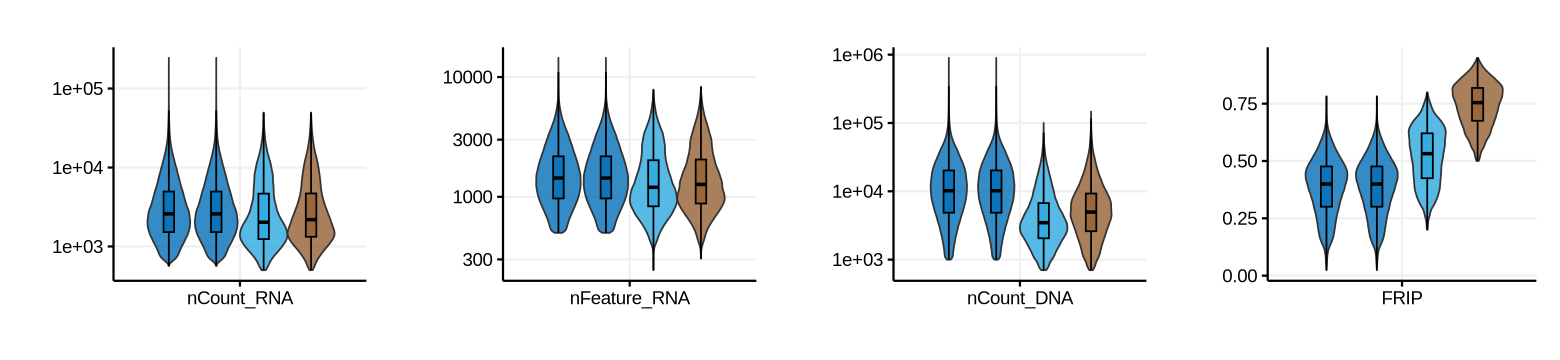

In [334]:
fig11 <- do.call(rbind, list(t11, t12, t2, t3)) %>%
filter(variable %in% c("nCount_RNA")) %>%
mutate(modality = factor(modality, levels = c("FNIH", "CAREHF", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
scale_y_log10() + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#036EB8", "#2EA7E0", "#956134")) + NoLegend()

fig12 <- do.call(rbind, list(t11, t12, t2, t3)) %>%
filter(variable %in% c("nFeature_RNA")) %>%
mutate(modality = factor(modality, levels = c("FNIH", "CAREHF", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
scale_y_log10() + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#036EB8", "#2EA7E0", "#956134")) + NoLegend()

fig2 <- do.call(rbind, list(t11, t12, t2, t3)) %>%
filter(variable %in% c("nCount_DNA")) %>%
mutate(modality = factor(modality, levels = c("FNIH", "CAREHF", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
scale_y_log10() + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#036EB8", "#2EA7E0", "#956134")) + NoLegend()

fig3 <- do.call(rbind, list(t11, t12, t2, t3)) %>%
filter(variable %in% c("FRIP")) %>%
mutate(modality = factor(modality, levels = c("FNIH", "CAREHF", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#036EB8", "#2EA7E0", "#956134")) + NoLegend()

options(repr.plot.width = 13, repr.plot.height = 3)
fig1 <- cowplot::plot_grid(fig11, fig12, fig2, fig3, ncol = 4, align = 'h')
fig1

ggsave(fig1, filename = "plot/FIG_alldata_QC_by_tech.pdf", dpi = 300, height = 3, width = 13)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


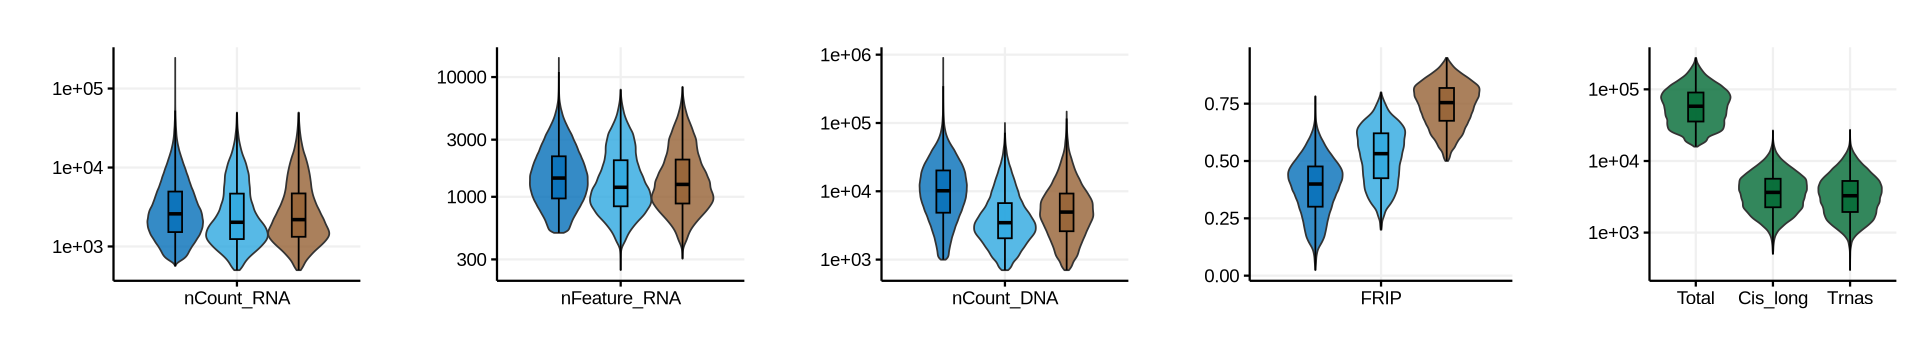

In [152]:
fig11 <- do.call(rbind, list(t1, t2, t3)) %>%
filter(variable %in% c("nCount_RNA")) %>%
mutate(modality = factor(modality, levels = c("Multiome", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
scale_y_log10() + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#2EA7E0", "#956134")) + NoLegend()

fig12 <- do.call(rbind, list(t1, t2, t3)) %>%
filter(variable %in% c("nFeature_RNA")) %>%
mutate(modality = factor(modality, levels = c("Multiome", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
scale_y_log10() + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#2EA7E0", "#956134")) + NoLegend()

fig2 <- do.call(rbind, list(t1, t2, t3)) %>%
filter(variable %in% c("nCount_DNA")) %>%
mutate(modality = factor(modality, levels = c("Multiome", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
scale_y_log10() + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#2EA7E0", "#956134")) + NoLegend()

fig3 <- do.call(rbind, list(t1, t2, t3)) %>%
filter(variable %in% c("FRIP")) %>%
mutate(modality = factor(modality, levels = c("Multiome", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#036EB8", "#2EA7E0", "#956134")) + NoLegend()

fig4 <- t4 %>%
filter(variable %in% c("Total", "Cis_long", "Trnas")) %>%
ggplot(aes(x = variable, y = value, fill = modality)) + 
geom_violin(alpha = 0.8) + 
geom_boxplot(width = 0.2, color = "black", alpha=0.8, 
             coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
scale_y_log10() + 
theme_Publication() + xlab("") + ylab("") +
scale_fill_manual(values = c("#006934")) + NoLegend()

options(repr.plot.width = 16, repr.plot.height = 3)
fig1 <- cowplot::plot_grid(fig11, fig12, fig2, fig3, fig4, ncol = 5, align = 'h')
fig1
ggsave(fig1, filename = "plot/FIG_alldata_QC_by_modality.pdf", dpi = 300, height = 3, width = 15)

### UMAP by modalities

In [155]:
ref <- readRDS("../reference/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds")
mmg <- qs::qread("FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX.qs")

In [80]:
jumap <- int@reductions$umap@cell.embeddings[colnames(ref),]
colnames(jumap) <- paste0("jointUMAP_", 1:2)
ref[['joint.umap']] <- CreateDimReducObject(embeddings = as.matrix(jumap), assay = "RNA", key = "jointUMAP")
ref

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from jointUMAP to jointUMAP_”


An object of class Seurat 
392885 features across 329255 samples within 4 assays 
Active assay: ATAC (285873 features, 285873 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 8 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn, joint.umap

In [162]:
mmg$atac_bc <- mmg$dna_bc
mmg$dna_bc <- paste0(mmg$dna, ":", mmg$atac_bc)

K27ac_umap <- read.csv("FNIH_Heart_pool.H3K27ac.umap.csv", row.names = 1)
K27me3_umap <- read.csv("FNIH_Heart_pool.H3K27me3.umap.csv", row.names = 1)
rownames(K27ac_umap) <- mmg@meta.data[match(rownames(K27ac_umap), mmg$dna_bc), ] %>% rownames
rownames(K27me3_umap) <- mmg@meta.data[match(rownames(K27me3_umap), mmg$dna_bc), ] %>% rownames
colnames(K27ac_umap) <- colnames(mmg@reductions$umap@cell.embeddings)
colnames(K27me3_umap) <- colnames(mmg@reductions$umap@cell.embeddings)

mmg <- subset(mmg, cells = c(rownames(K27ac_umap), rownames(K27me3_umap)))

### assign
mmg[["k27ac_umap"]] <- CreateDimReducObject(embeddings = as.matrix(K27ac_umap), key = "acUMAP_", assay = DefaultAssay(mmg))
mmg[["k27me3_umap"]] <- CreateDimReducObject(embeddings = as.matrix(K27me3_umap), key = "meUMAP_", assay = DefaultAssay(mmg))

mmg

An object of class Seurat 
70064 features across 131253 samples within 2 assays 
Active assay: SCT (33463 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 5 dimensional reductions calculated: pca, harmony, umap, k27ac_umap, k27me3_umap

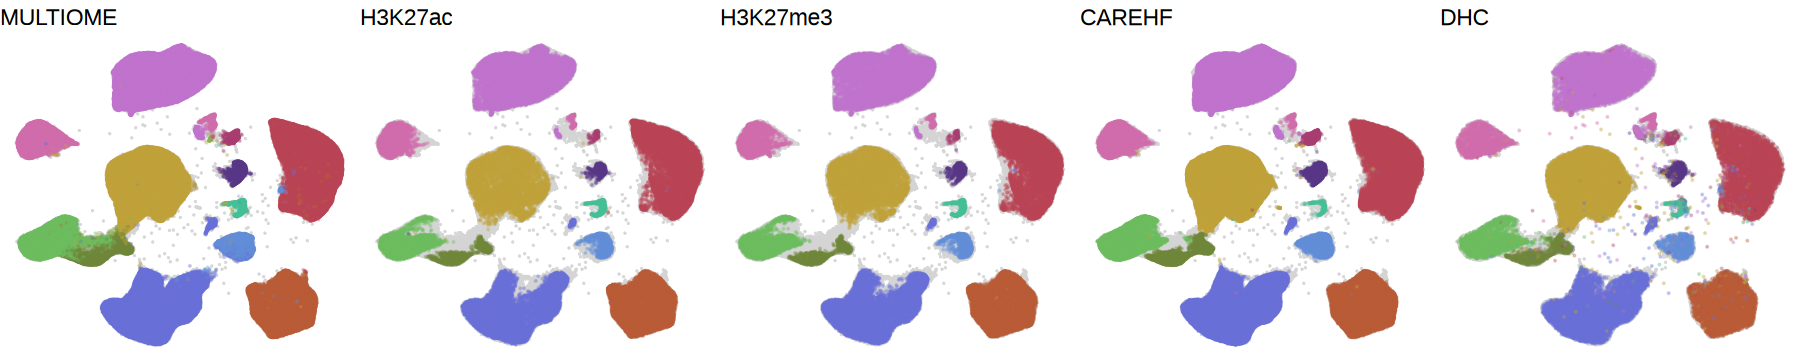

In [103]:
### add colors gray
qtable <- merge(int@meta.data[,c("nn2.celltype"),drop = F], int@reductions$umap@cell.embeddings, by = 0) %>%
tibble::column_to_rownames("Row.names")

qcell1 <- int@meta.data[int$orig.ident %in% c("MULTIOME") & int$integrated_majortype == "1", ] %>% rownames
qcell2 <- int@meta.data[int$orig.ident == "DPT" & int$integrated_majortype == "1" & int$Target == "H3K27ac", ] %>% rownames
qcell3 <- int@meta.data[int$orig.ident == "DPT" & int$integrated_majortype == "1" & int$Target == "H3K27me3", ] %>% rownames
qcell4 <- int@meta.data[int$orig.ident %in% c("CAREHF") & int$integrated_majortype == "1", ] %>% rownames
qcell5 <- int@meta.data[int$orig.ident %in% c("DHC"), ] %>% rownames

nlist <- c("MULTIOME", "H3K27ac", "H3K27me3", "CAREHF", "DHC")
plist <- list()

for (i in 1:5){
    qcell <- list(qcell1, qcell2, qcell3, qcell4, qcell5)[[i]]
    plist[[i]] <- qtable[!(rownames(qtable) %in% qcell),] %>%
    ggplot(aes(x = UMAP_1, y = UMAP_2)) + 
    geom_point_rast(size = 0.1, alpha = 0.8, color = "#D4D4D4") + 
    geom_point_rast(data = qtable[rownames(qtable) %in% qcell,], 
               aes(x = UMAP_1, y = UMAP_2, color = nn2.celltype), 
               size = 0.1, alpha = 0.3) + 
    theme_void() + NoLegend() + ggtitle(paste0(nlist[[i]])) + 
    scale_color_manual(values = celltype_colors)
}

options(repr.plot.width = 15, repr.plot.height = 3)
cowplot::plot_grid(plotlist = plist, ncol = 5)

In [106]:
for (i in 1:5){
    qcell <- list(qcell1, qcell2, qcell3, qcell4, qcell5)[[i]]
    plist[[i]] <- qtable[!(rownames(qtable) %in% qcell),] %>%
    ggplot(aes(x = UMAP_1, y = UMAP_2)) + 
    scattermore::geom_scattermore(size = 0.1, alpha = 0.8, color = "#D4D4D4") + 
    scattermore::geom_scattermore(data =  qtable[rownames(qtable) %in% qcell,], 
               aes(x = UMAP_1, y = UMAP_2, color = nn2.celltype), 
               size = 0.1, alpha = 0.3) + 
    theme_void() + NoLegend() + # ggtitle(paste0(nlist[[i]])) + 
    scale_color_manual(values = celltype_colors)
}

fig1 <- cowplot::plot_grid(plotlist = plist, nrow = 5)
ggsave(fig1, filename = "plot/FIG_RNA_UMAP_by_tech_grey.png", 
       dpi = 300, height = 20, width = 4)

In [108]:
for (i in 1:4){
    qcell <- list(c(qcell1, qcell4), qcell2, qcell3, qcell5)[[i]]
    plist[[i]] <- qtable[!(rownames(qtable) %in% qcell),] %>%
    ggplot(aes(x = UMAP_1, y = UMAP_2)) + 
    scattermore::geom_scattermore(size = 0.1, alpha = 0.8, color = "#D4D4D4") + 
    scattermore::geom_scattermore(data =  qtable[rownames(qtable) %in% qcell,], 
               aes(x = UMAP_1, y = UMAP_2, color = nn2.celltype), 
               size = 0.1, alpha = 0.3) + 
    theme_void() + NoLegend() + # ggtitle(paste0(nlist[[i]])) + 
    scale_color_manual(values = celltype_colors)
}

fig1 <- cowplot::plot_grid(plotlist = plist, nrow = 4)
ggsave(fig1, filename = "plot/FIG_RNA_UMAP_by_modality_grey.png", 
       dpi = 300, height = 20, width = 5)

Warning message:
“Removing 245534 cells missing data for vars requested”
Warning message:
“Removing 14 cells missing data for vars requested”
Warning message:
“Removing 29 cells missing data for vars requested”


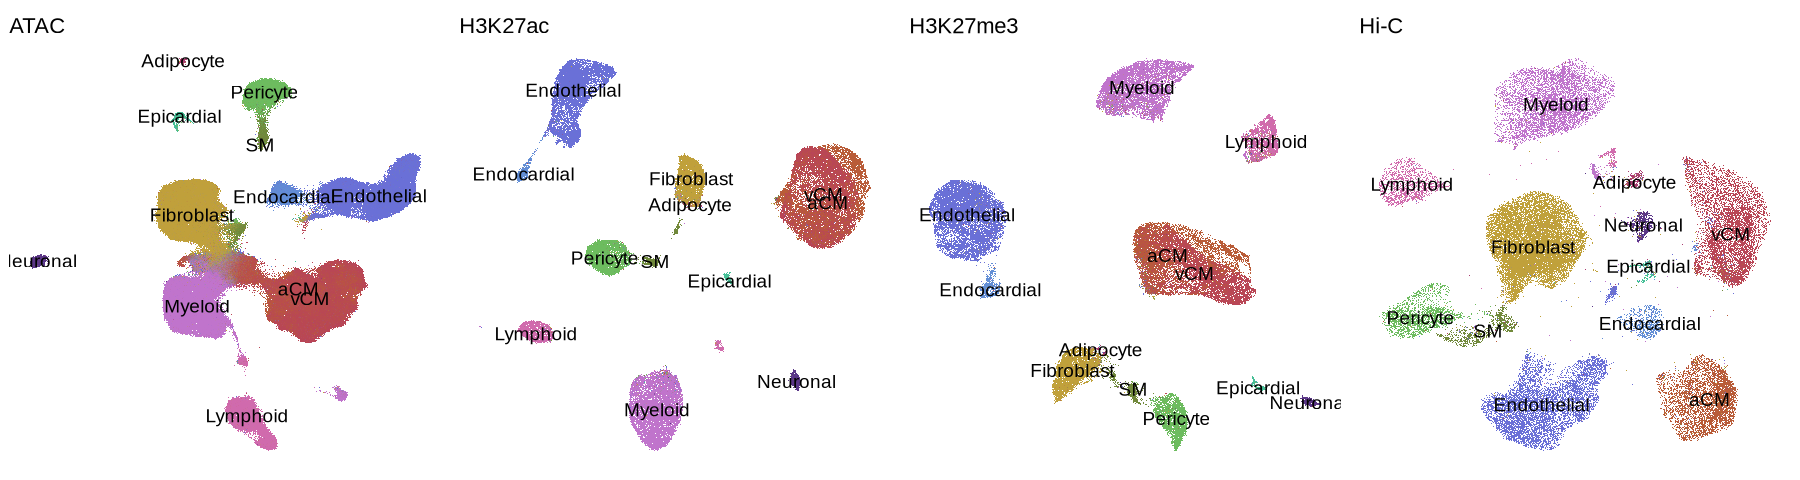

In [167]:
t1 <- DimPlot(ref, group.by = "cell.major_types", cols = celltype_colors, label = T, 
              reduction = "umap.atac", cells = cell1, raster = T) + ggtitle("ATAC") + theme_void() + NoLegend()
t2 <- DimPlot(mmg, group.by = "predicted.celltype", cols = celltype_colors, label = T, 
              reduction = "k27ac_umap", cells = cell2, raster = T) + ggtitle("H3K27ac") + theme_void() + NoLegend()
t3 <- DimPlot(mmg, group.by = "predicted.celltype", cols = celltype_colors, label = T, 
              reduction = "k27me3_umap", cells = cell3, raster = T) + ggtitle("H3K27me3") + theme_void() + NoLegend()
t4 <- DimPlot(int, group.by = "nn2.celltype", cols = celltype_colors, label = T, 
              reduction = "umap", cells = cell4, raster = T) + ggtitle("Hi-C") + theme_void() + NoLegend()

options(repr.plot.width = 15, repr.plot.height = 4)
cowplot::plot_grid(t1, t2, t3, t4, ncol = 4)

## Plot abc links

In [140]:
rpkm <- read.table("integration/FNIH_Heart_pool.int.rpkm.txt", row.names = 1, header = T)
atac <- read.table("../reference/ATAC_celltype.cpm.txt", header = T)
rownames(atac) <- sub("-", ":", rownames(atac))
k27ac <- read.csv("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.cpm.csv", row.names = 1)
k27me3 <- read.csv("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.cpm.csv", row.names = 1)
dim(atac)
dim(k27ac)
dim(k27me3)

[1] 285873     12

[1] 285873     12

[1] 285873     12

In [141]:
### remove blacklist?
suppressPackageStartupMessages(library(GenomicRanges))
bl <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/hg38-blacklist.v2.bed")
blr <- GRanges(bl$V1, IRanges::IRanges(bl$V2, bl$V3))

peak <- stringr::str_split_fixed(rownames(atac), pattern = "[:-]", n = 3) %>% as.data.frame
prange <- GRanges(peak$V1, IRanges::IRanges(as.integer(peak$V2), as.integer(peak$V3)))
bll <- peak[queryHits(findOverlaps(prange, blr)),] %>% mutate(range = paste0(V1, ":", V2, "-", V3))

share <- setdiff(rownames(atac), bll$range)
k27ac <- k27ac[share, ]
atac <- atac[share, ]
k27me3 <- k27me3[share, ]

In [142]:
### For marker genses, find the regulated elements and plot epigenetics mark
### use ABC links
abc <- list()
for (f in list.files("../../87.FNIH_DHC_IGM_240925/05.R/abc/celltype/", pattern = ".*_H3K27ac.cpm$")){
    fname <- sub("_H3K27ac.cpm", "", f)
    abc[[fname]] <- read.table(paste0("../../87.FNIH_DHC_IGM_240925/05.R/abc/celltype/output/", fname, "/EnhancerPredictions.txt"), header = T, sep = "\t") %>%
    mutate(range = paste0(chr, ":", start, "-", end), CellType = fname) %>% 
    filter(ABC.Score > 0.02) %>% select(c(range, TargetGene, TargetGeneTSS, CellType))
}

abc <- do.call(rbind, abc)

In [122]:
ccre <- abc %>% filter(TargetGene == "MYH6") %>% select(range) %>% unlist %>% unique
qregion <- stringr::str_split_fixed(ccre, pattern = "[:-]", n = 3)
write.table(qregion, "MYH6_enhancer.bed", sep = "\t", quote = F, row.names = F, col.names = F)

In [145]:
mtp <- c("MYL2", "MYH6", "WT1", "ACTA2", "PDGFRB", "NRXN1", "PDGFRA", "ADIPOQ", "CDH5", "SMOC1", "C1QC", "CD3E")
amtp <- intersect(mtp, abc$TargetGene)

ataccor <- accor <- mecor <- matrix(data = 0, nrow = length(mtp), 
                                    ncol = length(corder), dimnames = list(mtp, corder))
for (f in amtp){
    ccre <- abc %>% filter(TargetGene == f) %>% select(range) %>% unlist %>% unique
    ataccor[f,] <- apply(atac[ccre,corder], MARGIN = 2, mean, na.rm = TRUE)
    accor[f,] <- apply(k27ac[ccre,corder], MARGIN = 2, mean, na.rm = TRUE)
    mecor[f,] <- apply(k27me3[ccre,corder], MARGIN = 2, mean, na.rm = TRUE)
}

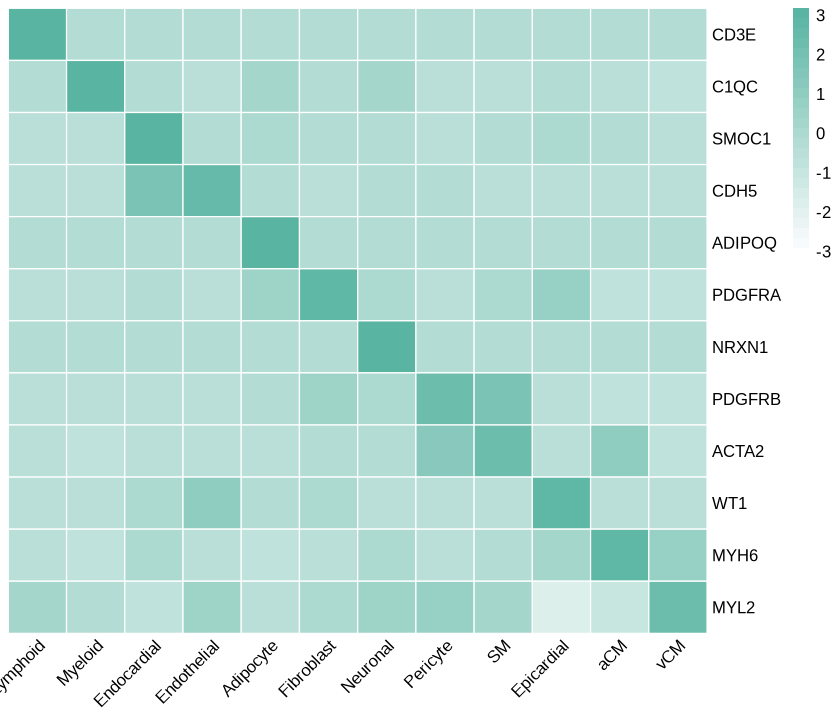

In [146]:
t0 <- log2(rpkm[rev(amtp), corder] + 1) %>%
pheatmap(scale = "row",cluster_rows = F, cluster_cols = F, angle_col = 45, 
         show_rownames = T, border_color = "white", color = colorRampPalette(c("white", "#59b4a2"))(25))

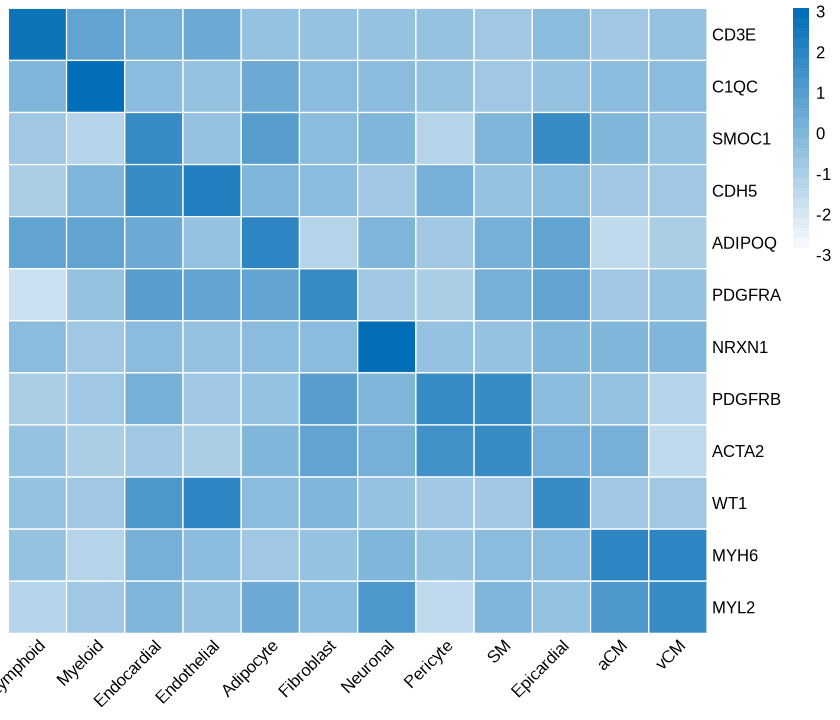

In [147]:
smat <- log2(ataccor[rev(amtp), corder] + 1)
t1 <- smat %>%
pheatmap(scale = "row",cluster_rows = F, cluster_cols = F, angle_col = 45, 
         border_color = "white", color = colorRampPalette(c("white", "#036EB8"))(25))

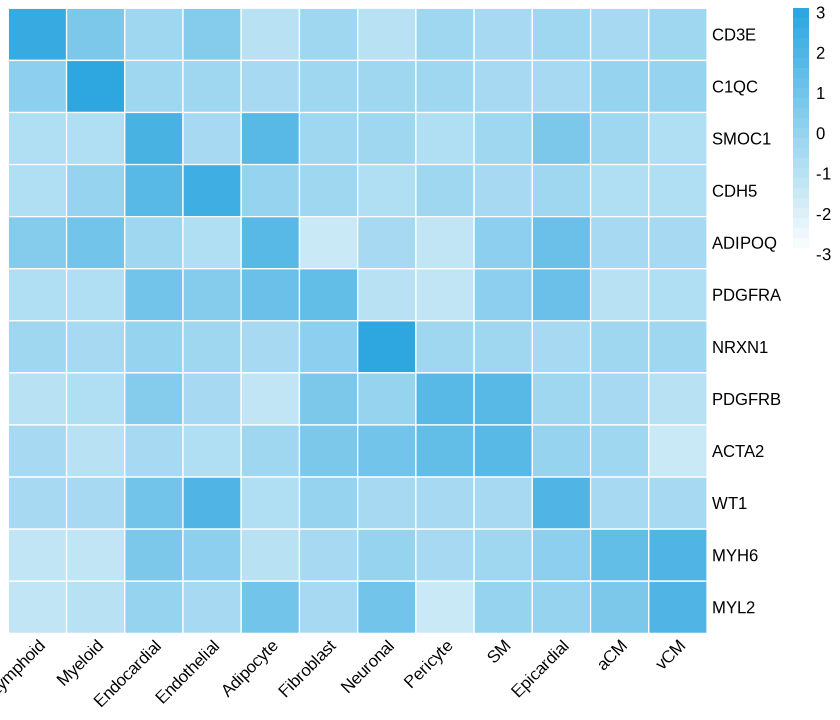

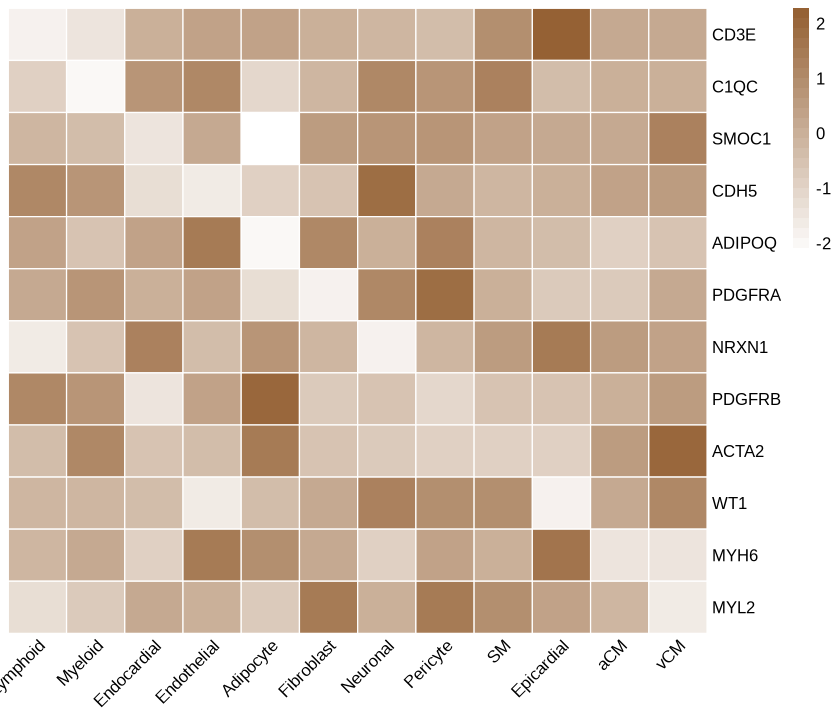

In [148]:
qmat <- log2(accor + 1)[rownames(smat), colnames(smat)]
t2 <- qmat %>%
pheatmap(scale = "row",cluster_rows = F, cluster_cols = F, angle_col = 45, 
         show_rownames = T, 
         border_color = "white", color = colorRampPalette(c("white", "#2EA7E0"))(25))

qmat <- log2(mecor + 1)[rownames(smat), colnames(smat)]

t3 <- qmat %>%
pheatmap(scale = "row",cluster_rows = F, cluster_cols = F, angle_col = 45, 
         show_rownames = T,
         border_color = "white", color = colorRampPalette(c("white", "#956134"))(25))

`summarise()` has grouped output by 'TargetGene'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`summarise()` has grouped output by 'range'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


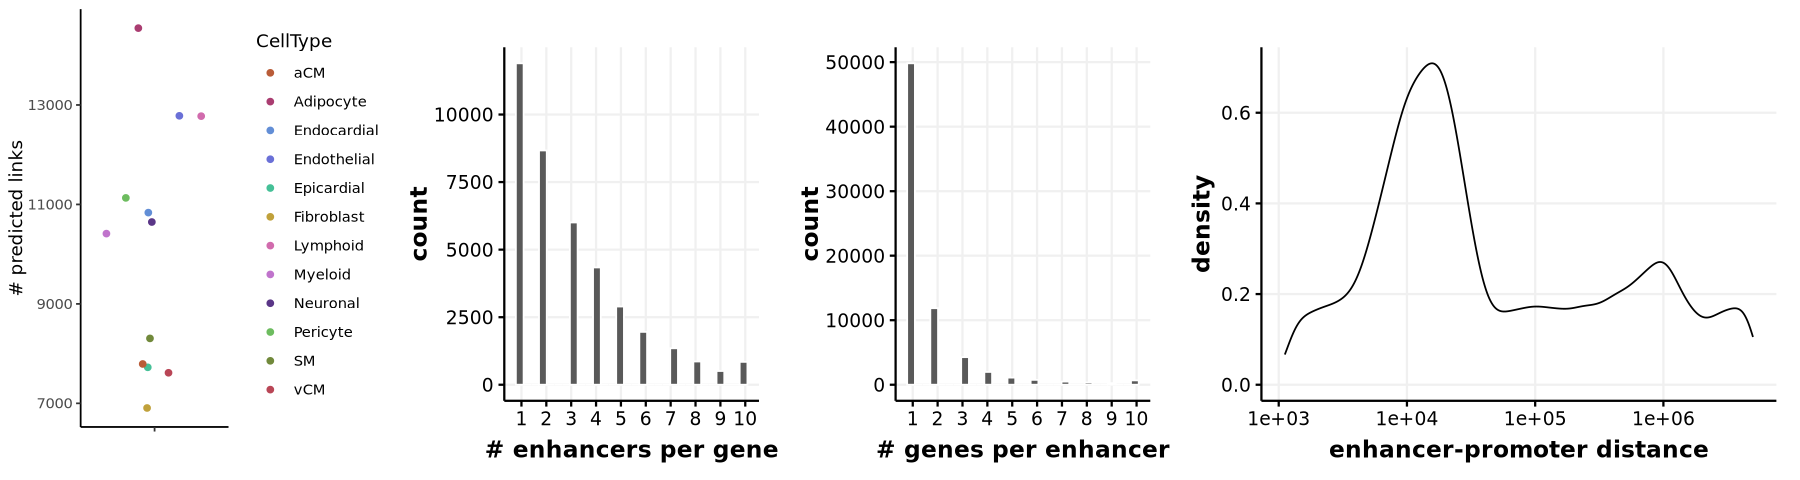

In [461]:
### Summarize abc link
t0 <- abc %>% group_by(CellType) %>%
summarise(npairs = n_distinct(across(everything()))) %>%
ungroup() %>%
ggplot(aes(x = "", y = npairs)) + 
geom_jitter(aes(color = CellType)) + 
theme_classic() + xlab("") + ylab("# predicted links") + 
scale_color_manual(values = celltype_colors) 

t1 <- abc %>% group_by(TargetGene, CellType) %>%
summarise(nen = length(unique(range))) %>%
ungroup() %>%
mutate(nen = ifelse(nen > 10, 10, nen)) %>%
ggplot(aes(x = nen)) + 
geom_histogram(color = "white") + 
# scale_x_log10() + 
scale_x_continuous(breaks = seq(1, 10, 1)) + xlab("# enhancers per gene") + 
theme_Publication() 

t2 <- abc %>% group_by(range, CellType) %>%
summarise(nen = length(unique(TargetGene))) %>%
ungroup() %>%
mutate(nen = ifelse(nen > 10, 10, nen)) %>%
ggplot(aes(x = nen)) + 
geom_histogram(color = "white") + 
# scale_x_log10() + 
scale_x_continuous(breaks = seq(1, 10, 1)) + xlab("# genes per enhancer") +  
theme_Publication()

t3 <- abc %>% 
mutate(center = apply(as.data.frame(stringr::str_split_fixed(abc$range, pattern = "[:-]", n = 3)[,2:3]), MARGIN = 1, function(x) mean(as.integer(x)))) %>%
mutate(dist = abs(center - TargetGeneTSS)) %>%
ggplot(aes(x = dist)) + 
geom_density() + 
# geom_histogram(color = "white") + 
scale_x_log10() + xlab("enhancer-promoter distance") +  
theme_Publication()

options(repr.plot.width = 15, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t0, t1, t2, t3, ncol = 4, rel_widths = c(0.5, 0.5, 0.5, 0.8))
fig1              
ggsave(fig1, filename = "plot/FIG_abc_link_celltype_states.summary.pdf", dpi = 300, height = 4, width = 14)